# Objective 1: DICOM loading and visualization

## Import libraries

In [61]:
import pydicom
import highdicom
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt,  animation
import scipy
import cv2

import constants as ct
import utils
from utils import load_ct, load_ct_series, load_segmentation, load_pixelarray_positions, reslice_segmentations

3D Slicer

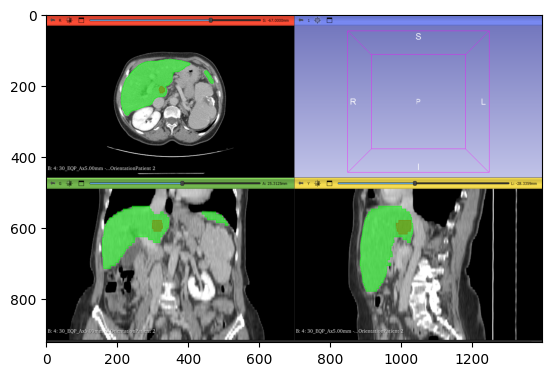

In [ ]:
img = cv2.imread("3DSLICER.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 1. Load Headers 

In [32]:
slice = ct.REFERENCE_IMAGE + 'dicom-00011.dcm'
ref_img = load_ct(slice)
print(ref_img.AcquisitionNumber)
print(ref_img.InstanceNumber)
print(ref_img.SliceLocation)
print(ref_img.SliceThickness)
print(ref_img.PixelSpacing)
print(ref_img.ImagePositionPatient)

print(ref_img)

sliceThickness = ref_img.SliceThickness
pixelSpacing = ref_img.PixelSpacing

3
11
-37.000000
5.000000
[0.703125, 0.703125]
[-189.351562, -189.140625, -37.000000]
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 180
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.5.3608459.17369.1404888965.118
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'REFORMATTED', 'AVERAGE']
(0008,0012) Instance Creation Date              DA: ''
(0008,0013) Instance Creation Time              TM: '135637'
(0008,0016) SOP Class UID

In [33]:
slice_liver = ct.LIVER_SEGMENTATION 
liver = load_ct(slice_liver)

print(liver.PerFrameFunctionalGroupsSequence[0].PlanePositionSequence[0])
print(liver.PerFrameFunctionalGroupsSequence[0].SegmentIdentificationSequence[0])
print(liver)

(0020,0032) Image Position (Patient)            DS: [-189.351562, -189.140625, -172.000000]
(0062,000B) Referenced Segment Number           US: 1
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 212
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.511.3.12781606542265803940952557144609255
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.9.7433.1.1
(0002,0013) Implementation Version Name         SH: 'highdicom0.22.0'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008,0016) SOP Class UID                       UI: Segmentation Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.3

In [34]:
slice_tumor = ct.TUMOR_SEGMENTATION 
tumor = load_ct(slice_tumor)

print(tumor.PerFrameFunctionalGroupsSequence[0].PlanePositionSequence[0])
print(tumor.PerFrameFunctionalGroupsSequence[0].SegmentIdentificationSequence[0])
print(tumor)

(0020,0032) Image Position (Patient)            DS: [-189.351562, -189.140625, -97.000000]
(0062,000B) Referenced Segment Number           US: 1
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 212
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.511.3.12862897345503801995229124137857530
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.9.7433.1.1
(0002,0013) Implementation Version Name         SH: 'highdicom0.22.0'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008,0016) SOP Class UID                       UI: Segmentation Storage
(0008,0018) SOP Instance UID                    UI: 1.2.826.0.1.36

## 2. Load all the slices

In [35]:
ct_volume, slice_positions, number = load_ct_series(ct.REFERENCE_IMAGE)
print(f"Check if all the slices contain only a single acquisition: {np.unique(number)}")   


The reference CT volume has a shape of: (54, 512, 512)
Check if all the slices contain only a single acquisition: [3]


## 3. Load and reslice segmentations

In [36]:
liver_segmented =load_segmentation(slice_liver)
liver_seg = liver_segmented.pixel_array
print("LIVER ROI SHAPE: ", liver_seg.shape)

tumor_segmented = load_segmentation(slice_tumor)
tumor_seg = tumor_segmented.pixel_array
print("TUMOR ROI SHAPE: ", tumor_seg.shape)

LIVER ROI SHAPE:  (32, 512, 512)
TUMOR ROI SHAPE:  (11, 512, 512)


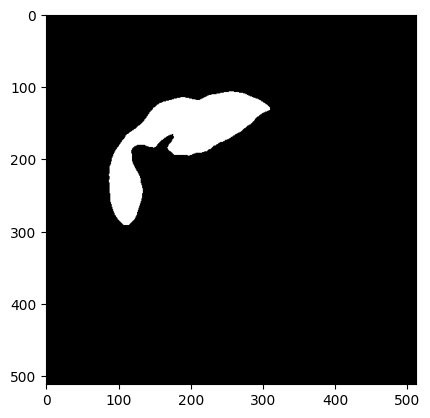

In [37]:
plt.imshow(liver_seg[12,:,:], cmap='gray')

In [38]:
for item in liver_segmented.SegmentSequence:
    print(item.SegmentLabel, item.SegmentNumber)

for item in tumor_segmented.SegmentSequence:
    print(item.SegmentLabel, item.SegmentNumber)

Liver 1
Tumor 1


In [39]:
liver_array, liver_pos = load_pixelarray_positions(liver_segmented)
liver_volume = reslice_segmentations(ct_volume.shape,liver_pos,slice_positions, liver_array, label_value=1)
print(liver_volume.shape)

tumor_array, tumor_pos = load_pixelarray_positions(tumor_segmented)
tumor_volume = reslice_segmentations(ct_volume.shape,tumor_pos,slice_positions, tumor_array, label_value=2)
print(tumor_volume.shape)

(54, 512, 512)
(54, 512, 512)


In [40]:
print(np.unique(liver_volume))
print(np.unique(tumor_volume))

[0 1]
[0 2]


In [41]:
final_segmentation = liver_volume.copy()
final_segmentation[tumor_volume > 0] = tumor_volume[tumor_volume > 0]
print(np.unique(final_segmentation))

[0 1 2]


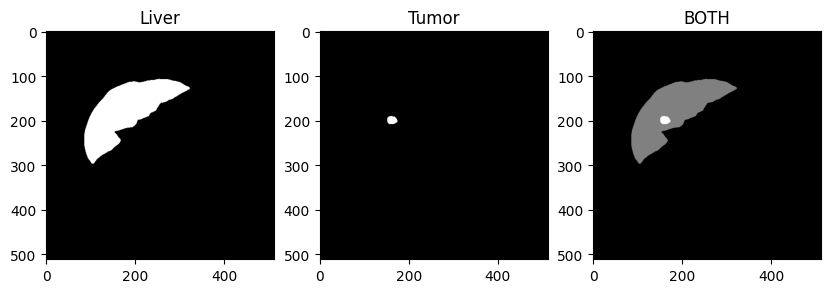

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(liver_volume[33,:,:], cmap='gray')
ax[0].set_title('Liver')
ax[1].imshow(tumor_volume[33,:,:], cmap='gray')
ax[1].set_title('Tumor')
ax[2].imshow(final_segmentation[33,:,:], cmap='gray')
ax[2].set_title('BOTH')
plt.show()

In [43]:
pixel_len = np.array([float(pixelSpacing[0]), float(pixelSpacing[1]), float(sliceThickness)])
print(pixel_len)
print(pixel_len[2]/pixel_len[0])
print(pixel_len[2]/pixel_len[1])

[0.703125 0.703125 5.      ]
7.111111111111111
7.111111111111111


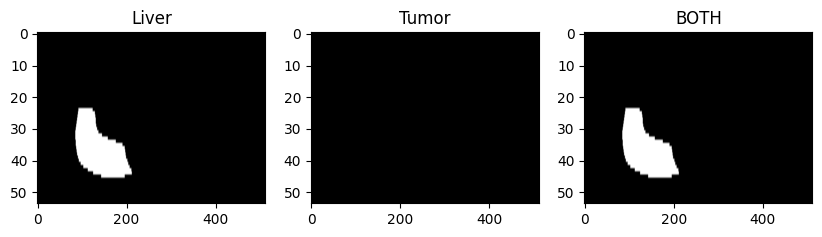

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(liver_volume[:,256,:], cmap='gray', aspect = pixel_len[2]/pixel_len[0] )
ax[0].set_title('Liver')
ax[1].imshow(tumor_volume[:,256,:], cmap='gray',  aspect = pixel_len[2]/pixel_len[0])
ax[1].set_title('Tumor')
ax[2].imshow(final_segmentation[:,256,:], cmap='gray',  aspect = pixel_len[2]/pixel_len[0])
ax[2].set_title('BOTH')
plt.show()

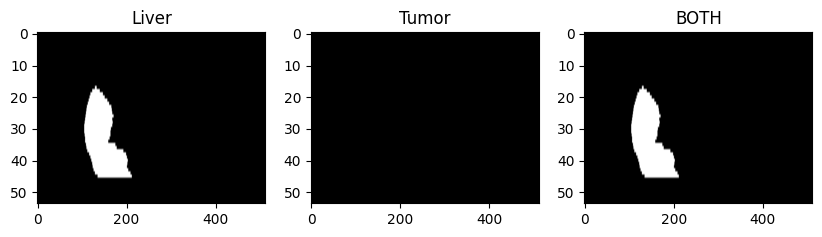

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))
ax[0].imshow(liver_volume[:,:,256], cmap='gray', aspect = pixel_len[2]/pixel_len[1] )
ax[0].set_title('Liver')
ax[1].imshow(tumor_volume[:,:,256], cmap='gray',  aspect = pixel_len[2]/pixel_len[1])
ax[1].set_title('Tumor')
ax[2].imshow(final_segmentation[:,:,256], cmap='gray',  aspect = pixel_len[2]/pixel_len[1])
ax[2].set_title('BOTH')
plt.show()

# Rotating MIP

In [46]:
def median_axial_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median axial plane of the CT image provided. """
    return img_dcm[img_dcm.shape[0]//2, :, :]

def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, :, img_dcm.shape[2]//2]

def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median coronal plane of the CT image provided. """
    return img_dcm[:, img_dcm.shape[1]//2, :]


def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)


def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)


def apply_cmap(img: np.ndarray, cmap_name: str = 'bone') -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    cmap_function = matplotlib.colormaps[cmap_name]
    return cmap_function(img)


def visualize_alpha_fusion(img: np.ndarray, mask: np.ndarray, alpha: float = 0.25, aspect: int = 1):
    """ Visualize both image and mask in the same plot. """

    img_cmapped = apply_cmap(img, cmap_name='bone')
    mask_bone_cmapped = apply_cmap(mask, cmap_name='flag')
    mask_bone_cmapped = mask_bone_cmapped * \
        (mask > 0)[..., np.newaxis].astype('bool')
    plt.imshow(img_cmapped * (1-alpha) +
               mask_bone_cmapped * alpha, aspect=aspect)
    plt.title(f'Mask with alpha {alpha}')
    plt.show()


def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

In [47]:
ct_volume = np.flip(ct_volume, axis=0) 
final_segmentation =  np.flip(final_segmentation, axis=0) 

In [48]:
slice_axial = median_axial_plane(ct_volume)
slice_sagittal = median_sagittal_plane(ct_volume)
slice_coronal = median_coronal_plane(ct_volume)
mip_sagittal = MIP_sagittal_plane(ct_volume)
mip_coronal = MIP_coronal_plane(ct_volume)

mask_sagittal = median_sagittal_plane(final_segmentation)
mask_coronal = median_coronal_plane(final_segmentation)
mip_mask_sagittal = MIP_sagittal_plane(final_segmentation)
mip_mask_coronal = MIP_coronal_plane(final_segmentation)

In [49]:
cm = matplotlib.colormaps['bone']

img_min_sag = np.min(slice_sagittal)
img_max_sag = np.max(slice_sagittal)
img_min_cor = np.min(slice_coronal)
img_max_cor = np.max(slice_coronal)
img_min_ax = np.min(slice_axial)
img_max_ax = np.max(slice_axial)

mip_min_sag = np.min(mip_sagittal)
mip_max_sag = np.max(mip_sagittal)
mip_min_cor = np.min(mip_coronal)
mip_max_cor = np.max(mip_coronal)

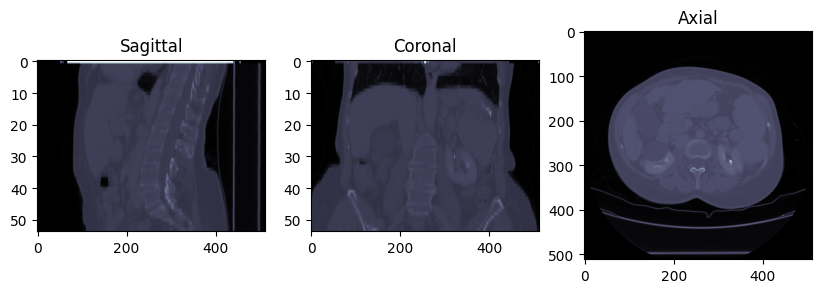

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(10,15))

ax[0].imshow(slice_sagittal, cmap=cm,vmin = img_min_sag, vmax = img_max_sag, aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Sagittal')
ax[1].imshow(slice_coronal, cmap=cm, vmin = img_min_cor, vmax = img_max_cor,aspect= (pixel_len[2]/pixel_len[1]))
ax[1].set_title('Coronal')
ax[2].imshow(slice_axial, cmap=cm,vmin = img_min_ax, vmax = img_max_ax)
ax[2].set_title('Axial')
plt.show()

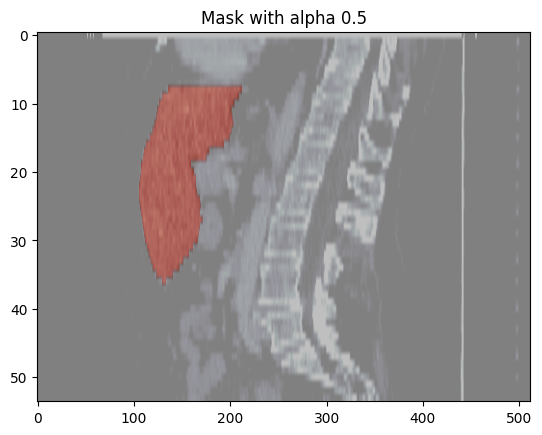

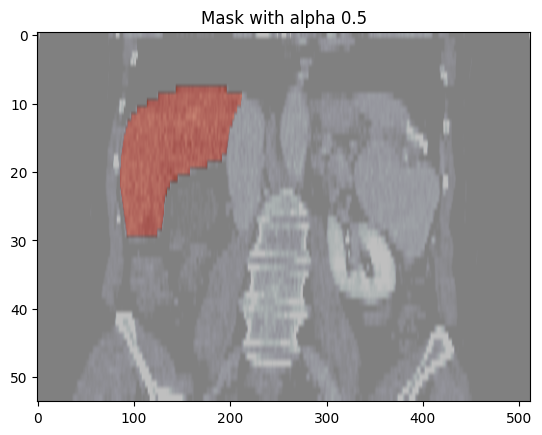

In [51]:
visualize_alpha_fusion(slice_sagittal, mask_sagittal, 0.5,(pixel_len[2]/pixel_len[0]))
visualize_alpha_fusion(slice_coronal, mask_coronal, 0.5,(pixel_len[2]/pixel_len[1]))

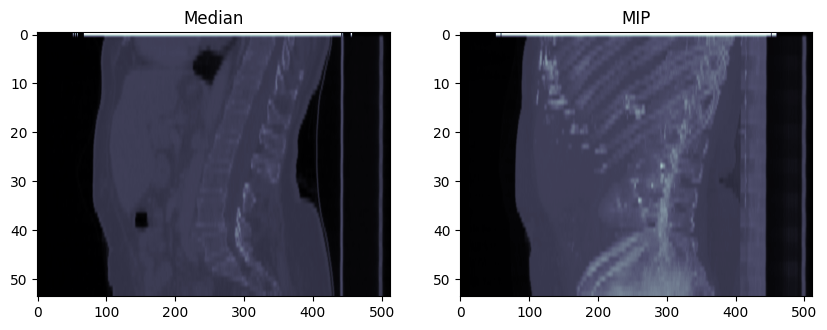

In [52]:
fig, ax = plt.subplots(1, 2,figsize=(10,15))
ax[0].imshow(slice_sagittal, cmap=cm,vmin = img_min_sag, vmax = img_max_sag,  aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Median')
ax[1].imshow(mip_sagittal, cmap=cm, vmin = mip_min_sag, vmax = mip_max_sag, aspect= (pixel_len[2]/pixel_len[0]))
ax[1].set_title('MIP')
plt.show()
   

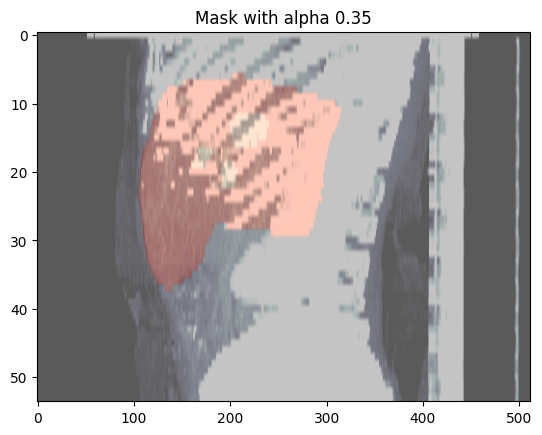

In [53]:
visualize_alpha_fusion(mip_sagittal,mip_mask_sagittal, 0.35,(pixel_len[2]/pixel_len[0]))

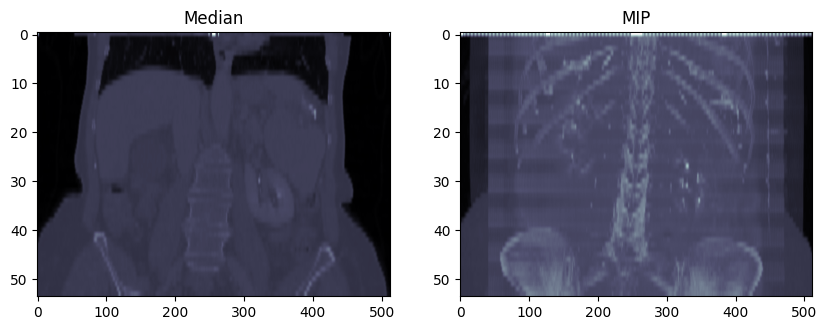

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10,15))
ax[0].imshow(slice_coronal,cmap=cm,vmin = img_min_cor, vmax = img_max_cor, aspect= (pixel_len[2]/pixel_len[0]))
ax[0].set_title('Median')
ax[1].imshow(mip_coronal, cmap=cm, vmin = mip_min_cor, vmax = mip_max_cor, aspect= (pixel_len[2]/pixel_len[0]))
ax[1].set_title('MIP')
plt.show()

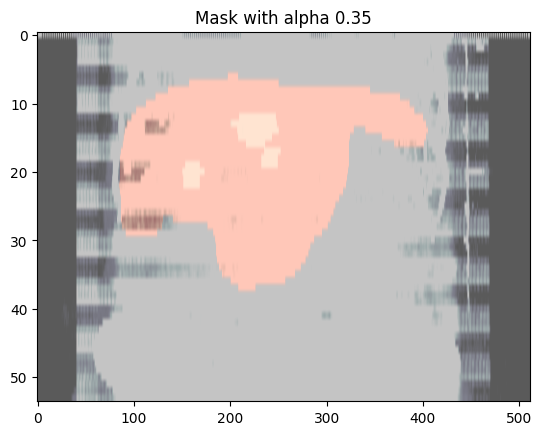

In [55]:
visualize_alpha_fusion(mip_coronal, mip_mask_coronal, 0.35,(pixel_len[2]/pixel_len[0]))

In [56]:
def save_animation(projections, min, max,name):
    animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=min, vmax=max, aspect=(pixel_len[2]/pixel_len[1]))]
    for img in projections
    ]
    anim = animation.ArtistAnimation(fig, animation_data,
                                interval=250, blit=True)
    anim.save(f'results/MIP/{name}/Animation.gif')  # Save animation
    plt.close(fig)

In [57]:
fig, ax = plt.subplots()
n = 16
projections1 = []

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    plt.imshow(projection, cmap=cm, vmin=mip_min_sag, vmax=mip_max_sag, aspect=(pixel_len[2]/pixel_len[0]))
    plt.savefig(f'results/MIP/Sagittal/Projection_{idx}.png')      
    projections1.append(projection)  
save_animation(projections1, mip_min_sag, mip_max_sag,'Sagittal')
  

MovieWriter ffmpeg unavailable; using Pillow instead.


In [58]:
fig, ax = plt.subplots()
n = 16
projections_alpha = []

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    rotated_mask = rotate_on_axial_plane(final_segmentation, alpha)


    projection = MIP_sagittal_plane(rotated_img)
    mask_projection = MIP_sagittal_plane(rotated_mask)

    img_cmapped = apply_cmap(projection, cmap_name='bone')
    mask_bone_cmapped = apply_cmap(mask_projection, cmap_name='flag')
    mask_bone_cmapped = mask_bone_cmapped * \
        (mask_projection > 0)[..., np.newaxis].astype('bool')
    
    union = img_cmapped * (1-0.35) + mask_bone_cmapped * 0.35

    plt.imshow(union, aspect=(pixel_len[2]/pixel_len[0]))
    plt.savefig(f'results/MIP/Alpha_Sagittal/Projection_{idx}.png')     
     
    projections_alpha.append(union)  
save_animation(projections_alpha, mip_min_sag, mip_max_sag,'Alpha_Sagittal')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [59]:
fig, ax = plt.subplots()
projections2 = []
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    projection = MIP_coronal_plane(rotated_img)
    plt.imshow(projection, cmap=cm, vmin=mip_min_cor, vmax=mip_max_cor, aspect=(pixel_len[2]/pixel_len[1]))
    plt.savefig(f'results/MIP/Coronal/Projection_{idx}.png')      
    projections2.append(projection) 
save_animation(projections2, mip_min_cor, mip_max_cor, 'Coronal')


MovieWriter ffmpeg unavailable; using Pillow instead.


In [60]:
fig, ax = plt.subplots()
n = 16
projections_alpha = []

for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(ct_volume, alpha)
    rotated_mask = rotate_on_axial_plane(final_segmentation, alpha)


    projection = MIP_coronal_plane(rotated_img)
    mask_projection = MIP_coronal_plane(rotated_mask)

    img_cmapped = apply_cmap(projection, cmap_name='bone')
    mask_bone_cmapped = apply_cmap(mask_projection, cmap_name='flag')
    mask_bone_cmapped = mask_bone_cmapped * \
        (mask_projection > 0)[..., np.newaxis].astype('bool')
    
    union = img_cmapped * (1-0.35) + mask_bone_cmapped * 0.35
    plt.imshow(union, aspect=(pixel_len[2]/pixel_len[1]))
    plt.savefig(f'results/MIP/Alpha_Coronal/Projection_{idx}.png')     
    projections_alpha.append(union)  

save_animation(projections_alpha, mip_min_cor, mip_max_cor,'Alpha_Coronal')

MovieWriter ffmpeg unavailable; using Pillow instead.


- we can suppose both images are the smae modality 
but we can use both 
